### 1. GAN first introduction
![GAN picture](./gan.png)



GANs are a class of unsupervised generative models which implicitly model the data density.

The basic setup is pictured above. There are two "competing" neural networks:
* The Generator wants to learn to generate realistic images that are indistinguishable from the real data. 
    - *input*: Gaussian noise random sample. *output*: a (higher dimensional) datapoint
* The Discriminator wants to tell the real & fake images apart.
    - *input*: datapoint/image, *output*: probability assigned to datapoint being real. Think binary classifier.
* The typical analogy: the generator is like a counterfeiter trying to look like real, the discriminator is the police trying to tell counterfeits from the real work.
* The key novelty of GANs is to pass the error signal (gradients) from the discriminator to the generator: the generator neural network uses the information from the competing discriminator neural network to know how to produce more realistic output.

### 2. Define the neural networks in pytorch

In [1]:
import sys
print(sys.version) # python 3.6
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
print(torch.__version__) # 1.0.1

%matplotlib inline
import matplotlib.pyplot as plt

def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]
1.11.0+cpu


Let's define a small 2-layer fully connected neural network (so one hidden layer) for the discriminator D:

In [2]:
class Discriminator(torch.nn.Module):
    def __init__(self, inp_dim=784):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(inp_dim, 128)
        self.nonlin1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 1)
    def forward(self, x):
        x = x.view(x.size(0), 784) # flatten (bs x 1 x 28 x 28) -> (bs x 784)
        h = self.nonlin1(self.fc1(x))
        out = self.fc2(h)
        out = torch.sigmoid(out)
        return out

And a small 2-layer neural network for the generator G. G takes a 100-dimensional noise vector and generates an output of the size matching the data.

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 128)
        self.nonlin1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 784)
    def forward(self, x):
        h = self.nonlin1(self.fc1(x))
        out = self.fc2(h)
        out = torch.tanh(out) # range [-1, 1]
        # convert to image 
        out = out.view(out.size(0), 1, 28, 28)
        return out

In [4]:
# instantiate a Generator and Discriminator according to their class definition.
D = Discriminator()
print(D)
G = Generator()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=784, bias=True)
)


Loading the data and computing forward pass

In [5]:
# let's download the Fashion MNIST data, if you do this locally and you downloaded before,
# you can change data paths to point to your existing files
# dataset = torchvision.datasets.MNIST(root='./MNISTdata', ...)
dataset = torchvision.datasets.FashionMNIST(root='./FashionMNIST/',
                       transform=transforms.Compose([transforms.ToTensor(),
                                                     transforms.Normalize((0.5,), (0.5,))]),
                       download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/FashionMNIST\raw\train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST\raw



Let's look at a sample:

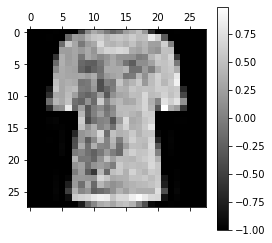

In [6]:
ix=149
x, _ = dataset[ix]
plt.matshow(x.squeeze().numpy(), cmap=plt.cm.gray)
plt.colorbar()

In [7]:
# for one image:
Dscore = D(x)
Dscore

tensor([[0.4996]], grad_fn=<SigmoidBackward0>)

In [8]:
# How you can get a batch of images from the dataloader:
xbatch, _ = iter(dataloader).next() # 64 x 1 x 28 x 28: minibatch of 64 samples
xbatch.shape
D(xbatch) # 64x1 tensor: 64 predictions of probability of input being real.
D(xbatch).shape

torch.Size([64, 1])

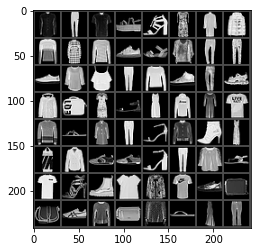

In [9]:
show_imgs(xbatch)

### 4. Back to GANs: The min-max game.
We introduced and defined the generator G, the discriminator D, and the dataloader which will give us minibatches of real data. With the intermezzo on optimization we also understand how we optimize neural networks in pytorch.

To recap the basic idea of the min-max / adversarial game:
* The Generator and Discriminator have competing objectives, they are "adversaries".
* The Discriminator wants to assign high probability to real images and low probability to generated (fake) images
* The Generator wants its generated images to look real, so wants to modify its outputs to get high scores from the Discriminator
* We will optimize both alternatingly, with SGD steps (as before): optimize $\theta_D$ the weights of $D(x, \theta_D)$, and  $\theta_G$ the weights of $G(z, \theta_G)$.
* Final goal of the whole min-max game is for the Generator to match the data distribution: $p_G(x) \approx p_{data}(x)$.


Now what are the objective functions for each of them? As mentioned in the introduction, the objective for the discriminator is to classify the real images as real, so $D(x) = 1$, and the fake images as fake, so $D(G(z))=0$.
This is a typical binary classification problem which calls for the binary cross-entropy (BCE) loss, which encourages exactly this solution.

For G we just try to minimize the same loss that D maximizes. See how G appears inside D? This shows how the output of the generator G is passed into the Discriminator to compute the loss.


This is the optimization problem:

$$
\min _{G} \max _{D} V(D, G)=\mathbb{E}_{\boldsymbol{x} \sim p_{\text { data }}(\boldsymbol{x})}[\log D(\boldsymbol{x})]+\mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}(\boldsymbol{z})}[\log (1-D(G(\boldsymbol{z})))]
$$

We will do a single SGD step alternatingly to maximize D, then minimize G.
In fact for G we use a modified (non-saturing) loss $-\log D(G(z))$. Different modifications of the loss and the relation to the distance between distributions $p_{data}$ and $p_{G}$ became a topic of research over the last years.


In [20]:
# Remember we have defined the discriminator and generator as:
D = Discriminator()
print(D)
G = Generator()
print(G)
# Now let's set up the optimizers
optimizerD = torch.optim.SGD(D.parameters(), lr=0.01)
optimizerG = torch.optim.SGD(G.parameters(), lr=0.01)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=784, bias=True)
)


In [21]:
# and the BCE criterion which computes the loss above:
criterion = nn.BCELoss()

In [22]:
# STEP 1: Discriminator optimization step
x_real, _ = iter(dataloader).next()
lab_real = torch.ones(64, 1)
lab_fake = torch.zeros(64, 1)
# reset accumulated gradients from previous iteration
optimizerD.zero_grad()

D_x = D(x_real)
lossD_real = criterion(D_x, lab_real)

z = torch.randn(64, 100) # random noise, 64 samples, z_dim=100
x_gen = G(z).detach()
D_G_z = D(x_gen)
lossD_fake = criterion(D_G_z, lab_fake)

lossD = lossD_real + lossD_fake
lossD.backward()
optimizerD.step()

# print(D_x.mean().item(), D_G_z.mean().item())

Some things to think about / try out / investigate:
* what are the mean probabilities for real and fake? print them and see how they change when executing the cell above a couple of times. Does this correspond to your expectation?
* can you confirm how the use of the criterion maps to the objective stated above?
* when calling backward, the derivative of the loss wrt **what** gets computed?
* what does `.detach()` do? Are the Generator parameters' gradients computed?

In [30]:
# STEP 2: Generator optimization step
# note how only one of the terms involves the Generator so this is the only one that matters for G.
# reset accumulated gradients from previous iteration
optimizerG.zero_grad()

z = torch.randn(64, 100) # random noise, 64 samples, z_dim=100
D_G_z = D(G(z))
lossG = criterion(D_G_z, lab_real) # -log D(G(z))

lossG.backward()
optimizerG.step()

print(D_G_z.mean().item())

0.22891280055046082


Again run this cell a couple of times. See how the generator increases its Discriminator score?

Some more things to ponder:
* Do the Generator parameters now receive gradients? Why (compared to previous loop)?
* From the definition of BCE loss confirm that this comes down to $-\log D(G(z))$

### Putting it all together: the full training loop

Modifications to the code:
* add device parameter to take GPU if available
* use [Adam optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) (an adaptive learning-rate variation of SGD with momentum)
* some very minimal logging

Device:  cpu
e0.i0/938 last mb D(x)=0.4637 D(G(z))=0.4864
e0.i100/938 last mb D(x)=0.9411 D(G(z))=0.3504
e0.i200/938 last mb D(x)=0.8060 D(G(z))=0.3180
e0.i300/938 last mb D(x)=0.9106 D(G(z))=0.1275
e0.i400/938 last mb D(x)=0.9407 D(G(z))=0.0818
e0.i500/938 last mb D(x)=0.5704 D(G(z))=0.2209
e0.i600/938 last mb D(x)=0.8604 D(G(z))=0.1800
e0.i700/938 last mb D(x)=0.7377 D(G(z))=0.2364
e0.i800/938 last mb D(x)=0.8607 D(G(z))=0.1724
e0.i900/938 last mb D(x)=0.7915 D(G(z))=0.2306
e1.i0/938 last mb D(x)=0.9120 D(G(z))=0.1393
e1.i100/938 last mb D(x)=0.6263 D(G(z))=0.5192
e1.i200/938 last mb D(x)=0.8474 D(G(z))=0.1629
e1.i300/938 last mb D(x)=0.6661 D(G(z))=0.3716
e1.i400/938 last mb D(x)=0.8765 D(G(z))=0.1206
e1.i500/938 last mb D(x)=0.6497 D(G(z))=0.3809
e1.i600/938 last mb D(x)=0.7653 D(G(z))=0.2610
e1.i700/938 last mb D(x)=0.6746 D(G(z))=0.2944
e1.i800/938 last mb D(x)=0.7289 D(G(z))=0.3117
e1.i900/938 last mb D(x)=0.8927 D(G(z))=0.1066
e2.i0/938 last mb D(x)=0.8559 D(G(z))=0.1125
e2.i10

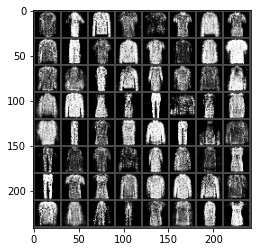

In [31]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device: ', device)
# Re-initialize D, G:
D = Discriminator().to(device)
G = Generator().to(device)
# Now let's set up the optimizers (Adam, better than SGD for this)
optimizerD = torch.optim.SGD(D.parameters(), lr=0.03)
optimizerG = torch.optim.SGD(G.parameters(), lr=0.03)
# optimizerD = torch.optim.Adam(D.parameters(), lr=0.0002)
# optimizerG = torch.optim.Adam(G.parameters(), lr=0.0002)
lab_real = torch.ones(64, 1, device=device)
lab_fake = torch.zeros(64, 1, device=device)


# for logging:
collect_x_gen = []
Generator_loss = []
Discriminator_loss = []
fixed_noise = torch.randn(64, 100, device=device)
fig = plt.figure() # keep updating this one
plt.ion()

for epoch in range(3): # 3 epochs
    for i, data in enumerate(dataloader, 0):
        # STEP 1: Discriminator optimization step
        x_real, _ = iter(dataloader).next()
        x_real = x_real.to(device)
        # reset accumulated gradients from previous iteration
        optimizerD.zero_grad()

        D_x = D(x_real)
        lossD_real = criterion(D_x, lab_real)

        z = torch.randn(64, 100, device=device) # random noise, 64 samples, z_dim=100
        x_gen = G(z).detach()
        D_G_z = D(x_gen)
        lossD_fake = criterion(D_G_z, lab_fake)

        lossD = lossD_real + lossD_fake
        Discriminator_loss.append(lossD.item())
        lossD.backward()
        optimizerD.step()
        
        # STEP 2: Generator optimization step
        # reset accumulated gradients from previous iteration
        optimizerG.zero_grad()

        z = torch.randn(64, 100, device=device) # random noise, 64 samples, z_dim=100
        x_gen = G(z)
        D_G_z = D(x_gen)
        lossG = criterion(D_G_z, lab_real) # -log D(G(z))
        Generator_loss.append(lossG.item())
        lossG.backward()
        optimizerG.step()
        if i % 100 == 0:
            x_gen = G(fixed_noise)
            show_imgs(x_gen, new_fig=False)
            fig.canvas.draw()
            print('e{}.i{}/{} last mb D(x)={:.4f} D(G(z))={:.4f}'.format(
                epoch, i, len(dataloader), D_x.mean().item(), D_G_z.mean().item()))
    # End of epoch
    x_gen = G(fixed_noise)
    collect_x_gen.append(x_gen.detach().clone())

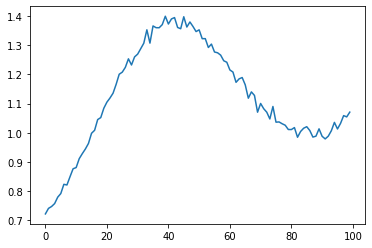

In [39]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(Generator_loss[0:100])

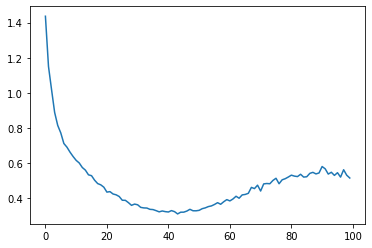

In [40]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(Discriminator_loss[0:100])

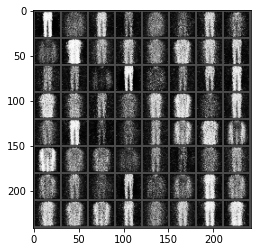

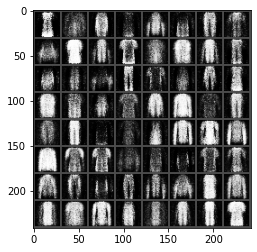

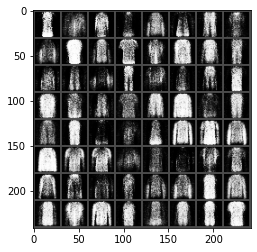

In [25]:
for x_gen in collect_x_gen:
    show_imgs(x_gen)

torch.Size([40, 100])


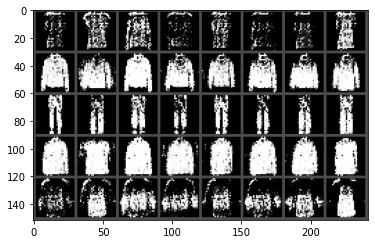

In [44]:
fixed_noise = torch.randn(8, 100, device=device)
fixed_noise = fixed_noise.repeat(5, 1)
for i in range(0, 8):
    fixed_noise[i][0] = 30
for i in range(8, 16):
    fixed_noise[i][20] = 30
for i in range(16, 24):
    fixed_noise[i][40] = 30
for i in range(24, 32):
    fixed_noise[i][60] = 30
for i in range(32, 40):
    fixed_noise[i][80] = 30

print(fixed_noise.shape)
x_gen = G(fixed_noise)
show_imgs(x_gen, new_fig=False)